# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more.



In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [5]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [6]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

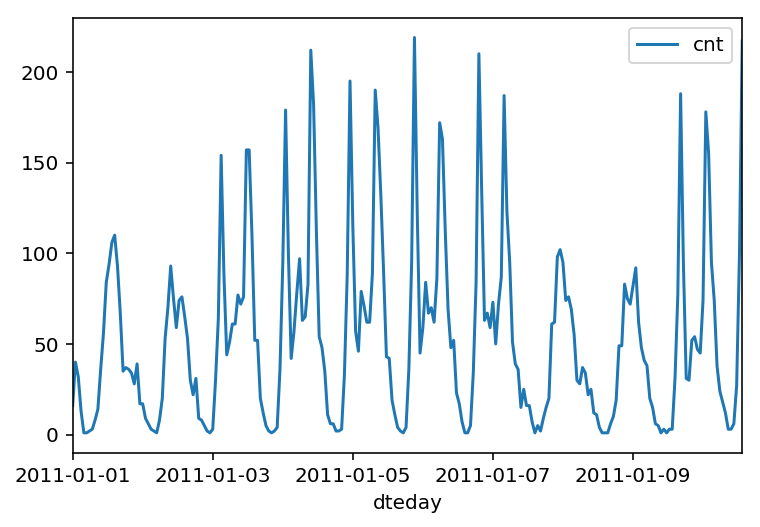

In [9]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [10]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [11]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [12]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [13]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Below you'll build your network. We've built out the structure and the backwards pass. You'll implement the forward pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

<img src="assets/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [36]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes ** -0.5,
                                                        (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes ** -0.5,
                                                         (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate

        #### TODO: Set self.activation_function to your implemented sigmoid function ####
        #
        # Note: in Python, you can define a function with a lambda expression,
        # as shown below.
        self.activation_function = lambda x: 1 / (1 + np.exp(-x))  # Replace 0 with your sigmoid calculation.

        ### If the lambda code above is not something you're familiar with,
        # You can uncomment out the following three lines and put your 
        # implementation there instead.
        #
        # def sigmoid(x):
        #    return 0  # Replace 0 with your sigmoid calculation here
        # self.activation_function = sigmoid


    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            #### Implement the forward pass here ####
            ### Forward pass ###
            # TODO: Hidden layer - Replace these values with your calculations.
            hidden_inputs = np.dot(X, self.weights_input_to_hidden)  # signals into hidden layer
            hidden_outputs = self.activation_function(hidden_inputs)  # signals from hidden layer

            # TODO: Output layer - Replace these values with your calculations.
            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output)  # signals into final output layer
            final_outputs = final_inputs  # signals from final output layer

            #### Implement the backward pass here ####
            ### Backward pass ###

            # TODO: Output error - Replace this value with your calculations.
            error = y - final_outputs  # Output layer error is the difference between desired target and actual output.
            hidden_error = np.dot(error, self.weights_hidden_to_output.T)
            output_error_term = error
            hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)

            # Weight step (hidden to output)
            delta_weights_h_o += output_error_term * hidden_outputs[:, None]
            # Weight step (input to hidden)
            delta_weights_i_h += hidden_error_term * X[:, None]


        # TODO: Update the weights - Replace these values with your calculations.
        self.weights_hidden_to_output += self.lr * delta_weights_h_o
        self.weights_input_to_hidden += self.lr * delta_weights_i_h

    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''

        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        hidden_inputs = np.dot(features, self.weights_input_to_hidden)  # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)  # signals from hidden layer

        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output)  # signals into final output layer
        final_outputs = final_inputs  # signals from final output layer

        return final_outputs

In [15]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [37]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.

.

.

.

.


----------------------------------------------------------------------
Ran 5 tests in 0.008s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations you use, the better the model will fit the data. However, if you use too many iterations, then the model with not generalize well to other data, this is called overfitting. You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. As you start overfitting, you'll see the training loss continue to decrease while the validation loss starts to increase.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.

In [30]:
import sys

### Set the hyperparameters here ###
iterations = 1000
learning_rate = 0.0025
hidden_nodes = 25
output_nodes = 250

N_i = train_features.shape[1]

network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)
losses = {'train': [], 'validation': []}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']

    network.train(X, y)

    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 0.0% ... Training loss: 1.144 ... Validation loss: 1.472

Progress: 0.1% ... Training loss: 0.954 ... Validation loss: 1.404

Progress: 0.2% ... Training loss: 0.917 ... Validation loss: 1.394

Progress: 0.3% ... Training loss: 0.880 ... Validation loss: 1.411

Progress: 0.4% ... Training loss: 0.814 ... Validation loss: 1.254

Progress: 0.5% ... Training loss: 0.773 ... Validation loss: 1.307

Progress: 0.6% ... Training loss: 0.727 ... Validation loss: 1.065

Progress: 0.7% ... Training loss: 0.653 ... Validation loss: 1.079

Progress: 0.8% ... Training loss: 0.628 ... Validation loss: 1.082

Progress: 0.9% ... Training loss: 0.635 ... Validation loss: 0.888

Progress: 1.0% ... Training loss: 0.678 ... Validation loss: 1.167

Progress: 1.1% ... Training loss: 0.571 ... Validation loss: 0.879

Progress: 1.2% ... Training loss: 0.561 ... Validation loss: 0.905

Progress: 1.3% ... Training loss: 0.786 ... Validation loss: 0.821

Progress: 1.4% ... Training loss: 0.783 ... Validation loss: 1.235

Progress: 1.5% ... Training loss: 0.576 ... Validation loss: 0.851

Progress: 1.6% ... Training loss: 0.512 ... Validation loss: 0.833

Progress: 1.7% ... Training loss: 0.516 ... Validation loss: 0.837

Progress: 1.8% ... Training loss: 0.554 ... Validation loss: 0.766

Progress: 1.9% ... Training loss: 0.594 ... Validation loss: 0.951

Progress: 2.0% ... Training loss: 0.452 ... Validation loss: 0.747

Progress: 2.1% ... Training loss: 0.430 ... Validation loss: 0.713

Progress: 2.2% ... Training loss: 0.430 ... Validation loss: 0.689

Progress: 2.3% ... Training loss: 0.461 ... Validation loss: 0.749

Progress: 2.4% ... Training loss: 0.473 ... Validation loss: 0.670

Progress: 2.5% ... Training loss: 0.611 ... Validation loss: 0.830

Progress: 2.6% ... Training loss: 0.434 ... Validation loss: 0.667

Progress: 2.7% ... Training loss: 0.447 ... Validation loss: 0.694

Progress: 2.8% ... Training loss: 0.621 ... Validation loss: 0.699

Progress: 2.9% ... Training loss: 0.424 ... Validation loss: 0.672

Progress: 3.0% ... Training loss: 0.397 ... Validation loss: 0.590

Progress: 3.1% ... Training loss: 0.368 ... Validation loss: 0.595

Progress: 3.2% ... Training loss: 0.361 ... Validation loss: 0.621

Progress: 3.3% ... Training loss: 0.342 ... Validation loss: 0.558

Progress: 3.4% ... Training loss: 0.352 ... Validation loss: 0.602

Progress: 3.5% ... Training loss: 0.451 ... Validation loss: 0.702

Progress: 3.6% ... Training loss: 0.498 ... Validation loss: 0.598

Progress: 3.7% ... Training loss: 0.799 ... Validation loss: 0.837

Progress: 3.8% ... Training loss: 0.581 ... Validation loss: 0.889

Progress: 3.9% ... Training loss: 0.431 ... Validation loss: 0.622

Progress: 4.0% ... Training loss: 0.373 ... Validation loss: 0.595

Progress: 4.1% ... Training loss: 0.348 ... Validation loss: 0.547

Progress: 4.2% ... Training loss: 0.330 ... Validation loss: 0.570

Progress: 4.3% ... Training loss: 0.335 ... Validation loss: 0.513

Progress: 4.4% ... Training loss: 0.336 ... Validation loss: 0.563

Progress: 4.5% ... Training loss: 0.321 ... Validation loss: 0.479

Progress: 4.6% ... Training loss: 0.378 ... Validation loss: 0.591

Progress: 4.7% ... Training loss: 0.474 ... Validation loss: 0.526

Progress: 4.8% ... Training loss: 0.361 ... Validation loss: 0.639

Progress: 4.9% ... Training loss: 0.322 ... Validation loss: 0.507

Progress: 5.0% ... Training loss: 0.299 ... Validation loss: 0.512

Progress: 5.1% ... Training loss: 0.319 ... Validation loss: 0.561

Progress: 5.2% ... Training loss: 0.326 ... Validation loss: 0.508

Progress: 5.3% ... Training loss: 0.304 ... Validation loss: 0.520

Progress: 5.4% ... Training loss: 0.308 ... Validation loss: 0.496

Progress: 5.5% ... Training loss: 0.370 ... Validation loss: 0.538

Progress: 5.6% ... Training loss: 0.355 ... Validation loss: 0.529

Progress: 5.7% ... Training loss: 0.312 ... Validation loss: 0.489

Progress: 5.8% ... Training loss: 0.340 ... Validation loss: 0.525

Progress: 5.9% ... Training loss: 0.457 ... Validation loss: 0.566

Progress: 6.0% ... Training loss: 0.371 ... Validation loss: 0.559

Progress: 6.1% ... Training loss: 0.301 ... Validation loss: 0.471

Progress: 6.2% ... Training loss: 0.279 ... Validation loss: 0.454

Progress: 6.3% ... Training loss: 0.269 ... Validation loss: 0.452

Progress: 6.4% ... Training loss: 0.273 ... Validation loss: 0.485

Progress: 6.5% ... Training loss: 0.295 ... Validation loss: 0.476

Progress: 6.6% ... Training loss: 0.295 ... Validation loss: 0.456

Progress: 6.7% ... Training loss: 0.332 ... Validation loss: 0.494

Progress: 6.8% ... Training loss: 0.350 ... Validation loss: 0.576

Progress: 6.9% ... Training loss: 0.311 ... Validation loss: 0.502

Progress: 7.0% ... Training loss: 0.272 ... Validation loss: 0.450

Progress: 7.1% ... Training loss: 0.299 ... Validation loss: 0.500

Progress: 7.2% ... Training loss: 0.255 ... Validation loss: 0.463

Progress: 7.3% ... Training loss: 0.253 ... Validation loss: 0.440

Progress: 7.4% ... Training loss: 0.241 ... Validation loss: 0.444

Progress: 7.5% ... Training loss: 0.267 ... Validation loss: 0.489

Progress: 7.6% ... Training loss: 0.252 ... Validation loss: 0.456

Progress: 7.7% ... Training loss: 0.242 ... Validation loss: 0.441

Progress: 7.8% ... Training loss: 0.238 ... Validation loss: 0.415

Progress: 7.9% ... Training loss: 0.279 ... Validation loss: 0.470

Progress: 8.0% ... Training loss: 0.299 ... Validation loss: 0.471

Progress: 8.1% ... Training loss: 0.358 ... Validation loss: 0.486

Progress: 8.2% ... Training loss: 0.257 ... Validation loss: 0.411

Progress: 8.3% ... Training loss: 0.239 ... Validation loss: 0.430

Progress: 8.4% ... Training loss: 0.251 ... Validation loss: 0.446

Progress: 8.5% ... Training loss: 0.385 ... Validation loss: 0.548

Progress: 8.6% ... Training loss: 0.277 ... Validation loss: 0.455

Progress: 8.7% ... Training loss: 0.228 ... Validation loss: 0.390

Progress: 8.8% ... Training loss: 0.226 ... Validation loss: 0.387

Progress: 8.9% ... Training loss: 0.211 ... Validation loss: 0.397

Progress: 9.0% ... Training loss: 0.244 ... Validation loss: 0.424

Progress: 9.1% ... Training loss: 0.227 ... Validation loss: 0.398

Progress: 9.2% ... Training loss: 0.263 ... Validation loss: 0.434

Progress: 9.3% ... Training loss: 0.244 ... Validation loss: 0.412

Progress: 9.4% ... Training loss: 0.226 ... Validation loss: 0.395

Progress: 9.5% ... Training loss: 0.207 ... Validation loss: 0.357

Progress: 9.6% ... Training loss: 0.259 ... Validation loss: 0.388

Progress: 9.7% ... Training loss: 0.359 ... Validation loss: 0.449

Progress: 9.8% ... Training loss: 0.305 ... Validation loss: 0.503

Progress: 9.9% ... Training loss: 0.219 ... Validation loss: 0.365

Progress: 10.0% ... Training loss: 0.208 ... Validation loss: 0.361

Progress: 10.1% ... Training loss: 0.199 ... Validation loss: 0.359

Progress: 10.2% ... Training loss: 0.203 ... Validation loss: 0.368

Progress: 10.3% ... Training loss: 0.227 ... Validation loss: 0.358

Progress: 10.4% ... Training loss: 0.203 ... Validation loss: 0.352

Progress: 10.5% ... Training loss: 0.194 ... Validation loss: 0.334

Progress: 10.6% ... Training loss: 0.196 ... Validation loss: 0.342

Progress: 10.7% ... Training loss: 0.200 ... Validation loss: 0.333

Progress: 10.8% ... Training loss: 0.192 ... Validation loss: 0.338

Progress: 10.9% ... Training loss: 0.190 ... Validation loss: 0.334

Progress: 11.0% ... Training loss: 0.187 ... Validation loss: 0.331

Progress: 11.1% ... Training loss: 0.200 ... Validation loss: 0.357

Progress: 11.2% ... Training loss: 0.189 ... Validation loss: 0.337

Progress: 11.3% ... Training loss: 0.202 ... Validation loss: 0.344

Progress: 11.4% ... Training loss: 0.187 ... Validation loss: 0.336

Progress: 11.5% ... Training loss: 0.195 ... Validation loss: 0.339

Progress: 11.6% ... Training loss: 0.186 ... Validation loss: 0.331

Progress: 11.7% ... Training loss: 0.187 ... Validation loss: 0.341

Progress: 11.8% ... Training loss: 0.177 ... Validation loss: 0.322

Progress: 11.9% ... Training loss: 0.176 ... Validation loss: 0.316

Progress: 12.0% ... Training loss: 0.176 ... Validation loss: 0.321

Progress: 12.1% ... Training loss: 0.177 ... Validation loss: 0.324

Progress: 12.2% ... Training loss: 0.173 ... Validation loss: 0.325

Progress: 12.3% ... Training loss: 0.174 ... Validation loss: 0.330

Progress: 12.4% ... Training loss: 0.172 ... Validation loss: 0.320

Progress: 12.5% ... Training loss: 0.173 ... Validation loss: 0.319

Progress: 12.6% ... Training loss: 0.183 ... Validation loss: 0.319

Progress: 12.7% ... Training loss: 0.209 ... Validation loss: 0.358

Progress: 12.8% ... Training loss: 0.218 ... Validation loss: 0.329

Progress: 12.9% ... Training loss: 0.181 ... Validation loss: 0.350

Progress: 13.0% ... Training loss: 0.174 ... Validation loss: 0.352

Progress: 13.1% ... Training loss: 0.167 ... Validation loss: 0.319

Progress: 13.2% ... Training loss: 0.190 ... Validation loss: 0.323

Progress: 13.3% ... Training loss: 0.175 ... Validation loss: 0.335

Progress: 13.4% ... Training loss: 0.173 ... Validation loss: 0.304

Progress: 13.5% ... Training loss: 0.178 ... Validation loss: 0.323

Progress: 13.6% ... Training loss: 0.181 ... Validation loss: 0.326

Progress: 13.7% ... Training loss: 0.166 ... Validation loss: 0.295

Progress: 13.8% ... Training loss: 0.166 ... Validation loss: 0.331

Progress: 13.9% ... Training loss: 0.166 ... Validation loss: 0.308

Progress: 14.0% ... Training loss: 0.168 ... Validation loss: 0.308

Progress: 14.1% ... Training loss: 0.171 ... Validation loss: 0.304

Progress: 14.2% ... Training loss: 0.157 ... Validation loss: 0.325

Progress: 14.3% ... Training loss: 0.157 ... Validation loss: 0.293

Progress: 14.4% ... Training loss: 0.157 ... Validation loss: 0.312

Progress: 14.5% ... Training loss: 0.236 ... Validation loss: 0.309

Progress: 14.6% ... Training loss: 0.170 ... Validation loss: 0.298

Progress: 14.7% ... Training loss: 0.164 ... Validation loss: 0.293

Progress: 14.8% ... Training loss: 0.161 ... Validation loss: 0.321

Progress: 14.9% ... Training loss: 0.172 ... Validation loss: 0.291

Progress: 15.0% ... Training loss: 0.157 ... Validation loss: 0.285

Progress: 15.1% ... Training loss: 0.180 ... Validation loss: 0.297

Progress: 15.2% ... Training loss: 0.230 ... Validation loss: 0.343

Progress: 15.3% ... Training loss: 0.275 ... Validation loss: 0.319

Progress: 15.4% ... Training loss: 0.278 ... Validation loss: 0.367

Progress: 15.5% ... Training loss: 0.352 ... Validation loss: 0.457

Progress: 15.6% ... Training loss: 0.185 ... Validation loss: 0.324

Progress: 15.7% ... Training loss: 0.178 ... Validation loss: 0.305

Progress: 15.8% ... Training loss: 0.160 ... Validation loss: 0.310

Progress: 15.9% ... Training loss: 0.159 ... Validation loss: 0.292

Progress: 16.0% ... Training loss: 0.156 ... Validation loss: 0.299

Progress: 16.1% ... Training loss: 0.162 ... Validation loss: 0.291

Progress: 16.2% ... Training loss: 0.149 ... Validation loss: 0.289

Progress: 16.3% ... Training loss: 0.150 ... Validation loss: 0.289

Progress: 16.4% ... Training loss: 0.148 ... Validation loss: 0.294

Progress: 16.5% ... Training loss: 0.147 ... Validation loss: 0.283

Progress: 16.6% ... Training loss: 0.146 ... Validation loss: 0.290

Progress: 16.7% ... Training loss: 0.153 ... Validation loss: 0.290

Progress: 16.8% ... Training loss: 0.150 ... Validation loss: 0.280

Progress: 16.9% ... Training loss: 0.147 ... Validation loss: 0.279

Progress: 17.0% ... Training loss: 0.142 ... Validation loss: 0.271

Progress: 17.1% ... Training loss: 0.143 ... Validation loss: 0.273

Progress: 17.2% ... Training loss: 0.143 ... Validation loss: 0.260

Progress: 17.3% ... Training loss: 0.160 ... Validation loss: 0.275

Progress: 17.4% ... Training loss: 0.146 ... Validation loss: 0.278

Progress: 17.5% ... Training loss: 0.136 ... Validation loss: 0.265

Progress: 17.6% ... Training loss: 0.139 ... Validation loss: 0.281

Progress: 17.7% ... Training loss: 0.139 ... Validation loss: 0.277

Progress: 17.8% ... Training loss: 0.135 ... Validation loss: 0.263

Progress: 17.9% ... Training loss: 0.138 ... Validation loss: 0.303

Progress: 18.0% ... Training loss: 0.136 ... Validation loss: 0.265

Progress: 18.1% ... Training loss: 0.138 ... Validation loss: 0.251

Progress: 18.2% ... Training loss: 0.136 ... Validation loss: 0.250

Progress: 18.3% ... Training loss: 0.146 ... Validation loss: 0.259

Progress: 18.4% ... Training loss: 0.162 ... Validation loss: 0.259

Progress: 18.5% ... Training loss: 0.157 ... Validation loss: 0.276

Progress: 18.6% ... Training loss: 0.138 ... Validation loss: 0.249

Progress: 18.7% ... Training loss: 0.134 ... Validation loss: 0.259

Progress: 18.8% ... Training loss: 0.136 ... Validation loss: 0.264

Progress: 18.9% ... Training loss: 0.157 ... Validation loss: 0.293

Progress: 19.0% ... Training loss: 0.149 ... Validation loss: 0.253

Progress: 19.1% ... Training loss: 0.178 ... Validation loss: 0.285

Progress: 19.2% ... Training loss: 0.290 ... Validation loss: 0.275

Progress: 19.3% ... Training loss: 0.211 ... Validation loss: 0.338

Progress: 19.4% ... Training loss: 0.169 ... Validation loss: 0.271

Progress: 19.5% ... Training loss: 0.149 ... Validation loss: 0.266

Progress: 19.6% ... Training loss: 0.152 ... Validation loss: 0.259

Progress: 19.7% ... Training loss: 0.137 ... Validation loss: 0.247

Progress: 19.8% ... Training loss: 0.148 ... Validation loss: 0.268

Progress: 19.9% ... Training loss: 0.133 ... Validation loss: 0.247

Progress: 20.0% ... Training loss: 0.145 ... Validation loss: 0.247

Progress: 20.1% ... Training loss: 0.126 ... Validation loss: 0.235

Progress: 20.2% ... Training loss: 0.159 ... Validation loss: 0.274

Progress: 20.3% ... Training loss: 0.131 ... Validation loss: 0.248

Progress: 20.4% ... Training loss: 0.131 ... Validation loss: 0.243

Progress: 20.5% ... Training loss: 0.125 ... Validation loss: 0.246

Progress: 20.6% ... Training loss: 0.137 ... Validation loss: 0.268

Progress: 20.7% ... Training loss: 0.123 ... Validation loss: 0.249

Progress: 20.8% ... Training loss: 0.127 ... Validation loss: 0.284

Progress: 20.9% ... Training loss: 0.119 ... Validation loss: 0.253

Progress: 21.0% ... Training loss: 0.136 ... Validation loss: 0.272

Progress: 21.1% ... Training loss: 0.118 ... Validation loss: 0.237

Progress: 21.2% ... Training loss: 0.125 ... Validation loss: 0.251

Progress: 21.3% ... Training loss: 0.162 ... Validation loss: 0.236

Progress: 21.4% ... Training loss: 0.150 ... Validation loss: 0.297

Progress: 21.5% ... Training loss: 0.152 ... Validation loss: 0.252

Progress: 21.6% ... Training loss: 0.129 ... Validation loss: 0.241

Progress: 21.7% ... Training loss: 0.121 ... Validation loss: 0.241

Progress: 21.8% ... Training loss: 0.116 ... Validation loss: 0.234

Progress: 21.9% ... Training loss: 0.117 ... Validation loss: 0.250

Progress: 22.0% ... Training loss: 0.167 ... Validation loss: 0.261

Progress: 22.1% ... Training loss: 0.212 ... Validation loss: 0.244

Progress: 22.2% ... Training loss: 0.255 ... Validation loss: 0.323

Progress: 22.3% ... Training loss: 0.250 ... Validation loss: 0.274

Progress: 22.4% ... Training loss: 0.190 ... Validation loss: 0.297

Progress: 22.5% ... Training loss: 0.210 ... Validation loss: 0.238

Progress: 22.6% ... Training loss: 0.140 ... Validation loss: 0.267

Progress: 22.7% ... Training loss: 0.121 ... Validation loss: 0.229

Progress: 22.8% ... Training loss: 0.121 ... Validation loss: 0.238

Progress: 22.9% ... Training loss: 0.118 ... Validation loss: 0.218

Progress: 23.0% ... Training loss: 0.112 ... Validation loss: 0.210

Progress: 23.1% ... Training loss: 0.118 ... Validation loss: 0.213

Progress: 23.2% ... Training loss: 0.119 ... Validation loss: 0.209

Progress: 23.3% ... Training loss: 0.147 ... Validation loss: 0.254

Progress: 23.4% ... Training loss: 0.127 ... Validation loss: 0.225

Progress: 23.5% ... Training loss: 0.159 ... Validation loss: 0.250

Progress: 23.6% ... Training loss: 0.128 ... Validation loss: 0.235

Progress: 23.7% ... Training loss: 0.125 ... Validation loss: 0.247

Progress: 23.8% ... Training loss: 0.115 ... Validation loss: 0.219

Progress: 23.9% ... Training loss: 0.137 ... Validation loss: 0.220

Progress: 24.0% ... Training loss: 0.133 ... Validation loss: 0.215

Progress: 24.1% ... Training loss: 0.109 ... Validation loss: 0.209

Progress: 24.2% ... Training loss: 0.108 ... Validation loss: 0.210

Progress: 24.3% ... Training loss: 0.107 ... Validation loss: 0.214

Progress: 24.4% ... Training loss: 0.116 ... Validation loss: 0.216

Progress: 24.5% ... Training loss: 0.113 ... Validation loss: 0.201

Progress: 24.6% ... Training loss: 0.106 ... Validation loss: 0.204

Progress: 24.7% ... Training loss: 0.117 ... Validation loss: 0.249

Progress: 24.8% ... Training loss: 0.128 ... Validation loss: 0.198

Progress: 24.9% ... Training loss: 0.212 ... Validation loss: 0.336

Progress: 25.0% ... Training loss: 0.163 ... Validation loss: 0.232

Progress: 25.1% ... Training loss: 0.209 ... Validation loss: 0.358

Progress: 25.2% ... Training loss: 0.118 ... Validation loss: 0.200

Progress: 25.3% ... Training loss: 0.111 ... Validation loss: 0.216

Progress: 25.4% ... Training loss: 0.106 ... Validation loss: 0.198

Progress: 25.5% ... Training loss: 0.103 ... Validation loss: 0.209

Progress: 25.6% ... Training loss: 0.106 ... Validation loss: 0.202

Progress: 25.7% ... Training loss: 0.101 ... Validation loss: 0.217

Progress: 25.8% ... Training loss: 0.123 ... Validation loss: 0.234

Progress: 25.9% ... Training loss: 0.107 ... Validation loss: 0.192

Progress: 26.0% ... Training loss: 0.105 ... Validation loss: 0.205

Progress: 26.1% ... Training loss: 0.103 ... Validation loss: 0.215

Progress: 26.2% ... Training loss: 0.109 ... Validation loss: 0.211

Progress: 26.3% ... Training loss: 0.120 ... Validation loss: 0.198

Progress: 26.4% ... Training loss: 0.111 ... Validation loss: 0.223

Progress: 26.5% ... Training loss: 0.102 ... Validation loss: 0.199

Progress: 26.6% ... Training loss: 0.097 ... Validation loss: 0.198

Progress: 26.7% ... Training loss: 0.099 ... Validation loss: 0.211

Progress: 26.8% ... Training loss: 0.098 ... Validation loss: 0.207

Progress: 26.9% ... Training loss: 0.094 ... Validation loss: 0.197

Progress: 27.0% ... Training loss: 0.094 ... Validation loss: 0.211

Progress: 27.1% ... Training loss: 0.094 ... Validation loss: 0.204

Progress: 27.2% ... Training loss: 0.092 ... Validation loss: 0.207

Progress: 27.3% ... Training loss: 0.094 ... Validation loss: 0.201

Progress: 27.4% ... Training loss: 0.092 ... Validation loss: 0.198

Progress: 27.5% ... Training loss: 0.096 ... Validation loss: 0.209

Progress: 27.6% ... Training loss: 0.096 ... Validation loss: 0.187

Progress: 27.7% ... Training loss: 0.094 ... Validation loss: 0.186

Progress: 27.8% ... Training loss: 0.098 ... Validation loss: 0.192

Progress: 27.9% ... Training loss: 0.137 ... Validation loss: 0.257

Progress: 28.0% ... Training loss: 0.192 ... Validation loss: 0.217

Progress: 28.1% ... Training loss: 0.160 ... Validation loss: 0.302

Progress: 28.2% ... Training loss: 0.143 ... Validation loss: 0.199

Progress: 28.3% ... Training loss: 0.113 ... Validation loss: 0.233

Progress: 28.4% ... Training loss: 0.092 ... Validation loss: 0.188

Progress: 28.5% ... Training loss: 0.097 ... Validation loss: 0.187

Progress: 28.6% ... Training loss: 0.095 ... Validation loss: 0.184

Progress: 28.7% ... Training loss: 0.097 ... Validation loss: 0.182

Progress: 28.8% ... Training loss: 0.105 ... Validation loss: 0.224

Progress: 28.9% ... Training loss: 0.095 ... Validation loss: 0.181

Progress: 29.0% ... Training loss: 0.097 ... Validation loss: 0.181

Progress: 29.1% ... Training loss: 0.095 ... Validation loss: 0.177

Progress: 29.2% ... Training loss: 0.088 ... Validation loss: 0.188

Progress: 29.3% ... Training loss: 0.094 ... Validation loss: 0.197

Progress: 29.4% ... Training loss: 0.118 ... Validation loss: 0.184

Progress: 29.5% ... Training loss: 0.118 ... Validation loss: 0.237

Progress: 29.6% ... Training loss: 0.161 ... Validation loss: 0.206

Progress: 29.7% ... Training loss: 0.280 ... Validation loss: 0.315

Progress: 29.8% ... Training loss: 0.392 ... Validation loss: 0.405

Progress: 29.9% ... Training loss: 0.257 ... Validation loss: 0.258

Progress: 30.0% ... Training loss: 0.149 ... Validation loss: 0.216

Progress: 30.1% ... Training loss: 0.112 ... Validation loss: 0.199

Progress: 30.2% ... Training loss: 0.104 ... Validation loss: 0.199

Progress: 30.3% ... Training loss: 0.103 ... Validation loss: 0.202

Progress: 30.4% ... Training loss: 0.103 ... Validation loss: 0.204

Progress: 30.5% ... Training loss: 0.105 ... Validation loss: 0.191

Progress: 30.6% ... Training loss: 0.093 ... Validation loss: 0.185

Progress: 30.7% ... Training loss: 0.103 ... Validation loss: 0.190

Progress: 30.8% ... Training loss: 0.104 ... Validation loss: 0.218

Progress: 30.9% ... Training loss: 0.102 ... Validation loss: 0.208

Progress: 31.0% ... Training loss: 0.090 ... Validation loss: 0.190

Progress: 31.1% ... Training loss: 0.098 ... Validation loss: 0.194

Progress: 31.2% ... Training loss: 0.089 ... Validation loss: 0.190

Progress: 31.3% ... Training loss: 0.089 ... Validation loss: 0.188

Progress: 31.4% ... Training loss: 0.088 ... Validation loss: 0.193

Progress: 31.5% ... Training loss: 0.087 ... Validation loss: 0.189

Progress: 31.6% ... Training loss: 0.103 ... Validation loss: 0.200

Progress: 31.7% ... Training loss: 0.095 ... Validation loss: 0.196

Progress: 31.8% ... Training loss: 0.098 ... Validation loss: 0.189

Progress: 31.9% ... Training loss: 0.107 ... Validation loss: 0.203

Progress: 32.0% ... Training loss: 0.087 ... Validation loss: 0.179

Progress: 32.1% ... Training loss: 0.087 ... Validation loss: 0.183

Progress: 32.2% ... Training loss: 0.091 ... Validation loss: 0.176

Progress: 32.3% ... Training loss: 0.087 ... Validation loss: 0.171

Progress: 32.4% ... Training loss: 0.085 ... Validation loss: 0.176

Progress: 32.5% ... Training loss: 0.092 ... Validation loss: 0.202

Progress: 32.6% ... Training loss: 0.117 ... Validation loss: 0.176

Progress: 32.7% ... Training loss: 0.108 ... Validation loss: 0.225

Progress: 32.8% ... Training loss: 0.089 ... Validation loss: 0.171

Progress: 32.9% ... Training loss: 0.092 ... Validation loss: 0.175

Progress: 33.0% ... Training loss: 0.092 ... Validation loss: 0.177

Progress: 33.1% ... Training loss: 0.088 ... Validation loss: 0.174

Progress: 33.2% ... Training loss: 0.090 ... Validation loss: 0.176

Progress: 33.3% ... Training loss: 0.099 ... Validation loss: 0.209

Progress: 33.4% ... Training loss: 0.083 ... Validation loss: 0.170

Progress: 33.5% ... Training loss: 0.086 ... Validation loss: 0.181

Progress: 33.6% ... Training loss: 0.092 ... Validation loss: 0.167

Progress: 33.7% ... Training loss: 0.086 ... Validation loss: 0.177

Progress: 33.8% ... Training loss: 0.086 ... Validation loss: 0.165

Progress: 33.9% ... Training loss: 0.086 ... Validation loss: 0.177

Progress: 34.0% ... Training loss: 0.082 ... Validation loss: 0.173

Progress: 34.1% ... Training loss: 0.080 ... Validation loss: 0.165

Progress: 34.2% ... Training loss: 0.083 ... Validation loss: 0.163

Progress: 34.3% ... Training loss: 0.080 ... Validation loss: 0.179

Progress: 34.4% ... Training loss: 0.092 ... Validation loss: 0.197

Progress: 34.5% ... Training loss: 0.097 ... Validation loss: 0.161

Progress: 34.6% ... Training loss: 0.146 ... Validation loss: 0.235

Progress: 34.7% ... Training loss: 0.156 ... Validation loss: 0.226

Progress: 34.8% ... Training loss: 0.156 ... Validation loss: 0.234

Progress: 34.9% ... Training loss: 0.093 ... Validation loss: 0.186

Progress: 35.0% ... Training loss: 0.089 ... Validation loss: 0.176

Progress: 35.1% ... Training loss: 0.096 ... Validation loss: 0.198

Progress: 35.2% ... Training loss: 0.095 ... Validation loss: 0.178

Progress: 35.3% ... Training loss: 0.085 ... Validation loss: 0.186

Progress: 35.4% ... Training loss: 0.081 ... Validation loss: 0.180

Progress: 35.5% ... Training loss: 0.084 ... Validation loss: 0.194

Progress: 35.6% ... Training loss: 0.097 ... Validation loss: 0.176

Progress: 35.7% ... Training loss: 0.081 ... Validation loss: 0.171

Progress: 35.8% ... Training loss: 0.082 ... Validation loss: 0.171

Progress: 35.9% ... Training loss: 0.078 ... Validation loss: 0.169

Progress: 36.0% ... Training loss: 0.079 ... Validation loss: 0.180

Progress: 36.1% ... Training loss: 0.097 ... Validation loss: 0.216

Progress: 36.2% ... Training loss: 0.086 ... Validation loss: 0.191

Progress: 36.3% ... Training loss: 0.085 ... Validation loss: 0.186

Progress: 36.4% ... Training loss: 0.083 ... Validation loss: 0.181

Progress: 36.5% ... Training loss: 0.083 ... Validation loss: 0.166

Progress: 36.6% ... Training loss: 0.079 ... Validation loss: 0.176

Progress: 36.7% ... Training loss: 0.086 ... Validation loss: 0.199

Progress: 36.8% ... Training loss: 0.081 ... Validation loss: 0.171

Progress: 36.9% ... Training loss: 0.082 ... Validation loss: 0.172

Progress: 37.0% ... Training loss: 0.077 ... Validation loss: 0.171

Progress: 37.1% ... Training loss: 0.084 ... Validation loss: 0.168

Progress: 37.2% ... Training loss: 0.097 ... Validation loss: 0.179

Progress: 37.3% ... Training loss: 0.090 ... Validation loss: 0.169

Progress: 37.4% ... Training loss: 0.098 ... Validation loss: 0.197

Progress: 37.5% ... Training loss: 0.085 ... Validation loss: 0.176

Progress: 37.6% ... Training loss: 0.083 ... Validation loss: 0.171

Progress: 37.7% ... Training loss: 0.079 ... Validation loss: 0.161

Progress: 37.8% ... Training loss: 0.084 ... Validation loss: 0.158

Progress: 37.9% ... Training loss: 0.082 ... Validation loss: 0.174

Progress: 38.0% ... Training loss: 0.084 ... Validation loss: 0.164

Progress: 38.1% ... Training loss: 0.084 ... Validation loss: 0.176

Progress: 38.2% ... Training loss: 0.077 ... Validation loss: 0.165

Progress: 38.3% ... Training loss: 0.076 ... Validation loss: 0.166

Progress: 38.4% ... Training loss: 0.075 ... Validation loss: 0.167

Progress: 38.5% ... Training loss: 0.080 ... Validation loss: 0.167

Progress: 38.6% ... Training loss: 0.078 ... Validation loss: 0.157

Progress: 38.7% ... Training loss: 0.097 ... Validation loss: 0.177

Progress: 38.8% ... Training loss: 0.077 ... Validation loss: 0.176

Progress: 38.9% ... Training loss: 0.085 ... Validation loss: 0.171

Progress: 39.0% ... Training loss: 0.076 ... Validation loss: 0.176

Progress: 39.1% ... Training loss: 0.076 ... Validation loss: 0.172

Progress: 39.2% ... Training loss: 0.079 ... Validation loss: 0.163

Progress: 39.3% ... Training loss: 0.075 ... Validation loss: 0.165

Progress: 39.4% ... Training loss: 0.084 ... Validation loss: 0.184

Progress: 39.5% ... Training loss: 0.081 ... Validation loss: 0.164

Progress: 39.6% ... Training loss: 0.080 ... Validation loss: 0.171

Progress: 39.7% ... Training loss: 0.090 ... Validation loss: 0.172

Progress: 39.8% ... Training loss: 0.077 ... Validation loss: 0.176

Progress: 39.9% ... Training loss: 0.075 ... Validation loss: 0.164

Progress: 40.0% ... Training loss: 0.081 ... Validation loss: 0.174

Progress: 40.1% ... Training loss: 0.083 ... Validation loss: 0.173

Progress: 40.2% ... Training loss: 0.076 ... Validation loss: 0.167

Progress: 40.3% ... Training loss: 0.074 ... Validation loss: 0.166

Progress: 40.4% ... Training loss: 0.089 ... Validation loss: 0.158

Progress: 40.5% ... Training loss: 0.080 ... Validation loss: 0.168

Progress: 40.6% ... Training loss: 0.083 ... Validation loss: 0.161

Progress: 40.7% ... Training loss: 0.088 ... Validation loss: 0.175

Progress: 40.8% ... Training loss: 0.079 ... Validation loss: 0.168

Progress: 40.9% ... Training loss: 0.077 ... Validation loss: 0.175

Progress: 41.0% ... Training loss: 0.079 ... Validation loss: 0.165

Progress: 41.1% ... Training loss: 0.075 ... Validation loss: 0.157

Progress: 41.2% ... Training loss: 0.079 ... Validation loss: 0.175

Progress: 41.3% ... Training loss: 0.076 ... Validation loss: 0.162

Progress: 41.4% ... Training loss: 0.081 ... Validation loss: 0.193

Progress: 41.5% ... Training loss: 0.074 ... Validation loss: 0.166

Progress: 41.6% ... Training loss: 0.074 ... Validation loss: 0.174

Progress: 41.7% ... Training loss: 0.073 ... Validation loss: 0.163

Progress: 41.8% ... Training loss: 0.078 ... Validation loss: 0.166

Progress: 41.9% ... Training loss: 0.073 ... Validation loss: 0.161

Progress: 42.0% ... Training loss: 0.072 ... Validation loss: 0.166

Progress: 42.1% ... Training loss: 0.077 ... Validation loss: 0.186

Progress: 42.2% ... Training loss: 0.084 ... Validation loss: 0.163

Progress: 42.3% ... Training loss: 0.078 ... Validation loss: 0.164

Progress: 42.4% ... Training loss: 0.079 ... Validation loss: 0.156

Progress: 42.5% ... Training loss: 0.076 ... Validation loss: 0.164

Progress: 42.6% ... Training loss: 0.075 ... Validation loss: 0.156

Progress: 42.7% ... Training loss: 0.080 ... Validation loss: 0.178

Progress: 42.8% ... Training loss: 0.074 ... Validation loss: 0.152

Progress: 42.9% ... Training loss: 0.077 ... Validation loss: 0.159

Progress: 43.0% ... Training loss: 0.076 ... Validation loss: 0.181

Progress: 43.1% ... Training loss: 0.074 ... Validation loss: 0.151

Progress: 43.2% ... Training loss: 0.081 ... Validation loss: 0.178

Progress: 43.3% ... Training loss: 0.075 ... Validation loss: 0.160

Progress: 43.4% ... Training loss: 0.074 ... Validation loss: 0.167

Progress: 43.5% ... Training loss: 0.074 ... Validation loss: 0.156

Progress: 43.6% ... Training loss: 0.080 ... Validation loss: 0.195

Progress: 43.7% ... Training loss: 0.078 ... Validation loss: 0.172

Progress: 43.8% ... Training loss: 0.074 ... Validation loss: 0.167

Progress: 43.9% ... Training loss: 0.087 ... Validation loss: 0.158

Progress: 44.0% ... Training loss: 0.083 ... Validation loss: 0.169

Progress: 44.1% ... Training loss: 0.106 ... Validation loss: 0.153

Progress: 44.2% ... Training loss: 0.082 ... Validation loss: 0.186

Progress: 44.3% ... Training loss: 0.079 ... Validation loss: 0.146

Progress: 44.4% ... Training loss: 0.086 ... Validation loss: 0.185

Progress: 44.5% ... Training loss: 0.101 ... Validation loss: 0.147

Progress: 44.6% ... Training loss: 0.090 ... Validation loss: 0.200

Progress: 44.7% ... Training loss: 0.088 ... Validation loss: 0.161

Progress: 44.8% ... Training loss: 0.111 ... Validation loss: 0.198

Progress: 44.9% ... Training loss: 0.108 ... Validation loss: 0.176

Progress: 45.0% ... Training loss: 0.088 ... Validation loss: 0.173

Progress: 45.1% ... Training loss: 0.080 ... Validation loss: 0.156

Progress: 45.2% ... Training loss: 0.076 ... Validation loss: 0.160

Progress: 45.3% ... Training loss: 0.078 ... Validation loss: 0.169

Progress: 45.4% ... Training loss: 0.076 ... Validation loss: 0.169

Progress: 45.5% ... Training loss: 0.074 ... Validation loss: 0.165

Progress: 45.6% ... Training loss: 0.072 ... Validation loss: 0.157

Progress: 45.7% ... Training loss: 0.070 ... Validation loss: 0.153

Progress: 45.8% ... Training loss: 0.074 ... Validation loss: 0.155

Progress: 45.9% ... Training loss: 0.077 ... Validation loss: 0.167

Progress: 46.0% ... Training loss: 0.074 ... Validation loss: 0.156

Progress: 46.1% ... Training loss: 0.100 ... Validation loss: 0.206

Progress: 46.2% ... Training loss: 0.072 ... Validation loss: 0.156

Progress: 46.3% ... Training loss: 0.073 ... Validation loss: 0.152

Progress: 46.4% ... Training loss: 0.073 ... Validation loss: 0.169

Progress: 46.5% ... Training loss: 0.069 ... Validation loss: 0.159

Progress: 46.6% ... Training loss: 0.073 ... Validation loss: 0.164

Progress: 46.7% ... Training loss: 0.080 ... Validation loss: 0.152

Progress: 46.8% ... Training loss: 0.073 ... Validation loss: 0.159

Progress: 46.9% ... Training loss: 0.072 ... Validation loss: 0.166

Progress: 47.0% ... Training loss: 0.072 ... Validation loss: 0.182

Progress: 47.1% ... Training loss: 0.072 ... Validation loss: 0.177

Progress: 47.2% ... Training loss: 0.071 ... Validation loss: 0.169

Progress: 47.3% ... Training loss: 0.069 ... Validation loss: 0.162

Progress: 47.4% ... Training loss: 0.069 ... Validation loss: 0.157

Progress: 47.5% ... Training loss: 0.113 ... Validation loss: 0.158

Progress: 47.6% ... Training loss: 0.076 ... Validation loss: 0.190

Progress: 47.7% ... Training loss: 0.081 ... Validation loss: 0.150

Progress: 47.8% ... Training loss: 0.071 ... Validation loss: 0.167

Progress: 47.9% ... Training loss: 0.074 ... Validation loss: 0.176

Progress: 48.0% ... Training loss: 0.077 ... Validation loss: 0.156

Progress: 48.1% ... Training loss: 0.104 ... Validation loss: 0.242

Progress: 48.2% ... Training loss: 0.096 ... Validation loss: 0.158

Progress: 48.3% ... Training loss: 0.111 ... Validation loss: 0.224

Progress: 48.4% ... Training loss: 0.071 ... Validation loss: 0.164

Progress: 48.5% ... Training loss: 0.072 ... Validation loss: 0.173

Progress: 48.6% ... Training loss: 0.076 ... Validation loss: 0.163

Progress: 48.7% ... Training loss: 0.080 ... Validation loss: 0.216

Progress: 48.8% ... Training loss: 0.077 ... Validation loss: 0.169

Progress: 48.9% ... Training loss: 0.071 ... Validation loss: 0.199

Progress: 49.0% ... Training loss: 0.073 ... Validation loss: 0.185

Progress: 49.1% ... Training loss: 0.070 ... Validation loss: 0.169

Progress: 49.2% ... Training loss: 0.071 ... Validation loss: 0.183

Progress: 49.3% ... Training loss: 0.070 ... Validation loss: 0.177

Progress: 49.4% ... Training loss: 0.072 ... Validation loss: 0.202

Progress: 49.5% ... Training loss: 0.069 ... Validation loss: 0.174

Progress: 49.6% ... Training loss: 0.070 ... Validation loss: 0.183

Progress: 49.7% ... Training loss: 0.106 ... Validation loss: 0.161

Progress: 49.8% ... Training loss: 0.096 ... Validation loss: 0.237

Progress: 49.9% ... Training loss: 0.078 ... Validation loss: 0.153

Progress: 50.0% ... Training loss: 0.070 ... Validation loss: 0.167

Progress: 50.1% ... Training loss: 0.077 ... Validation loss: 0.171

Progress: 50.2% ... Training loss: 0.072 ... Validation loss: 0.200

Progress: 50.3% ... Training loss: 0.085 ... Validation loss: 0.162

Progress: 50.4% ... Training loss: 0.086 ... Validation loss: 0.207

Progress: 50.5% ... Training loss: 0.098 ... Validation loss: 0.152

Progress: 50.6% ... Training loss: 0.084 ... Validation loss: 0.186

Progress: 50.7% ... Training loss: 0.079 ... Validation loss: 0.164

Progress: 50.8% ... Training loss: 0.071 ... Validation loss: 0.162

Progress: 50.9% ... Training loss: 0.070 ... Validation loss: 0.180

Progress: 51.0% ... Training loss: 0.080 ... Validation loss: 0.203

Progress: 51.1% ... Training loss: 0.093 ... Validation loss: 0.162

Progress: 51.2% ... Training loss: 0.073 ... Validation loss: 0.194

Progress: 51.3% ... Training loss: 0.079 ... Validation loss: 0.156

Progress: 51.4% ... Training loss: 0.077 ... Validation loss: 0.168

Progress: 51.5% ... Training loss: 0.083 ... Validation loss: 0.200

Progress: 51.6% ... Training loss: 0.085 ... Validation loss: 0.154

Progress: 51.7% ... Training loss: 0.084 ... Validation loss: 0.201

Progress: 51.8% ... Training loss: 0.072 ... Validation loss: 0.157

Progress: 51.9% ... Training loss: 0.075 ... Validation loss: 0.209

Progress: 52.0% ... Training loss: 0.067 ... Validation loss: 0.157

Progress: 52.1% ... Training loss: 0.069 ... Validation loss: 0.177

Progress: 52.2% ... Training loss: 0.069 ... Validation loss: 0.161

Progress: 52.3% ... Training loss: 0.070 ... Validation loss: 0.176

Progress: 52.4% ... Training loss: 0.070 ... Validation loss: 0.176

Progress: 52.5% ... Training loss: 0.072 ... Validation loss: 0.175

Progress: 52.6% ... Training loss: 0.075 ... Validation loss: 0.166

Progress: 52.7% ... Training loss: 0.070 ... Validation loss: 0.146

Progress: 52.8% ... Training loss: 0.071 ... Validation loss: 0.147

Progress: 52.9% ... Training loss: 0.068 ... Validation loss: 0.153

Progress: 53.0% ... Training loss: 0.069 ... Validation loss: 0.158

Progress: 53.1% ... Training loss: 0.071 ... Validation loss: 0.156

Progress: 53.2% ... Training loss: 0.079 ... Validation loss: 0.160

Progress: 53.3% ... Training loss: 0.071 ... Validation loss: 0.143

Progress: 53.4% ... Training loss: 0.072 ... Validation loss: 0.160

Progress: 53.5% ... Training loss: 0.080 ... Validation loss: 0.148

Progress: 53.6% ... Training loss: 0.072 ... Validation loss: 0.163

Progress: 53.7% ... Training loss: 0.083 ... Validation loss: 0.153

Progress: 53.8% ... Training loss: 0.138 ... Validation loss: 0.268

Progress: 53.9% ... Training loss: 0.211 ... Validation loss: 0.181

Progress: 54.0% ... Training loss: 0.409 ... Validation loss: 0.444

Progress: 54.1% ... Training loss: 0.314 ... Validation loss: 0.329

Progress: 54.2% ... Training loss: 0.217 ... Validation loss: 0.220

Progress: 54.3% ... Training loss: 0.186 ... Validation loss: 0.201

Progress: 54.4% ... Training loss: 0.149 ... Validation loss: 0.181

Progress: 54.5% ... Training loss: 0.130 ... Validation loss: 0.177

Progress: 54.6% ... Training loss: 0.110 ... Validation loss: 0.163

Progress: 54.7% ... Training loss: 0.097 ... Validation loss: 0.204

Progress: 54.8% ... Training loss: 0.089 ... Validation loss: 0.165

Progress: 54.9% ... Training loss: 0.088 ... Validation loss: 0.170

Progress: 55.0% ... Training loss: 0.081 ... Validation loss: 0.165

Progress: 55.1% ... Training loss: 0.078 ... Validation loss: 0.163

Progress: 55.2% ... Training loss: 0.077 ... Validation loss: 0.166

Progress: 55.3% ... Training loss: 0.077 ... Validation loss: 0.176

Progress: 55.4% ... Training loss: 0.085 ... Validation loss: 0.157

Progress: 55.5% ... Training loss: 0.074 ... Validation loss: 0.164

Progress: 55.6% ... Training loss: 0.076 ... Validation loss: 0.152

Progress: 55.7% ... Training loss: 0.074 ... Validation loss: 0.172

Progress: 55.8% ... Training loss: 0.074 ... Validation loss: 0.165

Progress: 55.9% ... Training loss: 0.076 ... Validation loss: 0.178

Progress: 56.0% ... Training loss: 0.077 ... Validation loss: 0.152

Progress: 56.1% ... Training loss: 0.084 ... Validation loss: 0.179

Progress: 56.2% ... Training loss: 0.078 ... Validation loss: 0.156

Progress: 56.3% ... Training loss: 0.076 ... Validation loss: 0.182

Progress: 56.4% ... Training loss: 0.069 ... Validation loss: 0.155

Progress: 56.5% ... Training loss: 0.082 ... Validation loss: 0.193

Progress: 56.6% ... Training loss: 0.069 ... Validation loss: 0.163

Progress: 56.7% ... Training loss: 0.072 ... Validation loss: 0.160

Progress: 56.8% ... Training loss: 0.071 ... Validation loss: 0.180

Progress: 56.9% ... Training loss: 0.074 ... Validation loss: 0.184

Progress: 57.0% ... Training loss: 0.091 ... Validation loss: 0.153

Progress: 57.1% ... Training loss: 0.070 ... Validation loss: 0.163

Progress: 57.2% ... Training loss: 0.073 ... Validation loss: 0.198

Progress: 57.3% ... Training loss: 0.071 ... Validation loss: 0.177

Progress: 57.4% ... Training loss: 0.069 ... Validation loss: 0.177

Progress: 57.5% ... Training loss: 0.068 ... Validation loss: 0.190

Progress: 57.6% ... Training loss: 0.070 ... Validation loss: 0.177

Progress: 57.7% ... Training loss: 0.075 ... Validation loss: 0.211

Progress: 57.8% ... Training loss: 0.069 ... Validation loss: 0.209

Progress: 57.9% ... Training loss: 0.073 ... Validation loss: 0.158

Progress: 58.0% ... Training loss: 0.066 ... Validation loss: 0.191

Progress: 58.1% ... Training loss: 0.068 ... Validation loss: 0.178

Progress: 58.2% ... Training loss: 0.069 ... Validation loss: 0.174

Progress: 58.3% ... Training loss: 0.074 ... Validation loss: 0.189

Progress: 58.4% ... Training loss: 0.072 ... Validation loss: 0.169

Progress: 58.5% ... Training loss: 0.071 ... Validation loss: 0.157

Progress: 58.6% ... Training loss: 0.065 ... Validation loss: 0.164

Progress: 58.7% ... Training loss: 0.069 ... Validation loss: 0.174

Progress: 58.8% ... Training loss: 0.071 ... Validation loss: 0.160

Progress: 58.9% ... Training loss: 0.068 ... Validation loss: 0.167

Progress: 59.0% ... Training loss: 0.066 ... Validation loss: 0.153

Progress: 59.1% ... Training loss: 0.068 ... Validation loss: 0.149

Progress: 59.2% ... Training loss: 0.067 ... Validation loss: 0.149

Progress: 59.3% ... Training loss: 0.066 ... Validation loss: 0.167

Progress: 59.4% ... Training loss: 0.066 ... Validation loss: 0.173

Progress: 59.5% ... Training loss: 0.069 ... Validation loss: 0.159

Progress: 59.6% ... Training loss: 0.068 ... Validation loss: 0.157

Progress: 59.7% ... Training loss: 0.067 ... Validation loss: 0.148

Progress: 59.8% ... Training loss: 0.067 ... Validation loss: 0.167

Progress: 59.9% ... Training loss: 0.067 ... Validation loss: 0.165

Progress: 60.0% ... Training loss: 0.065 ... Validation loss: 0.155

Progress: 60.1% ... Training loss: 0.065 ... Validation loss: 0.152

Progress: 60.2% ... Training loss: 0.066 ... Validation loss: 0.146

Progress: 60.3% ... Training loss: 0.081 ... Validation loss: 0.167

Progress: 60.4% ... Training loss: 0.089 ... Validation loss: 0.245

Progress: 60.5% ... Training loss: 0.079 ... Validation loss: 0.145

Progress: 60.6% ... Training loss: 0.079 ... Validation loss: 0.161

Progress: 60.7% ... Training loss: 0.069 ... Validation loss: 0.144

Progress: 60.8% ... Training loss: 0.067 ... Validation loss: 0.160

Progress: 60.9% ... Training loss: 0.068 ... Validation loss: 0.151

Progress: 61.0% ... Training loss: 0.079 ... Validation loss: 0.175

Progress: 61.1% ... Training loss: 0.092 ... Validation loss: 0.148

Progress: 61.2% ... Training loss: 0.100 ... Validation loss: 0.202

Progress: 61.3% ... Training loss: 0.080 ... Validation loss: 0.143

Progress: 61.4% ... Training loss: 0.074 ... Validation loss: 0.165

Progress: 61.5% ... Training loss: 0.084 ... Validation loss: 0.167

Progress: 61.6% ... Training loss: 0.070 ... Validation loss: 0.155

Progress: 61.7% ... Training loss: 0.074 ... Validation loss: 0.143

Progress: 61.8% ... Training loss: 0.068 ... Validation loss: 0.140

Progress: 61.9% ... Training loss: 0.068 ... Validation loss: 0.140

Progress: 62.0% ... Training loss: 0.067 ... Validation loss: 0.153

Progress: 62.1% ... Training loss: 0.072 ... Validation loss: 0.155

Progress: 62.2% ... Training loss: 0.072 ... Validation loss: 0.141

Progress: 62.3% ... Training loss: 0.066 ... Validation loss: 0.169

Progress: 62.4% ... Training loss: 0.066 ... Validation loss: 0.164

Progress: 62.5% ... Training loss: 0.070 ... Validation loss: 0.168

Progress: 62.6% ... Training loss: 0.068 ... Validation loss: 0.146

Progress: 62.7% ... Training loss: 0.075 ... Validation loss: 0.172

Progress: 62.8% ... Training loss: 0.081 ... Validation loss: 0.141

Progress: 62.9% ... Training loss: 0.069 ... Validation loss: 0.169

Progress: 63.0% ... Training loss: 0.069 ... Validation loss: 0.168

Progress: 63.1% ... Training loss: 0.070 ... Validation loss: 0.192

Progress: 63.2% ... Training loss: 0.064 ... Validation loss: 0.171

Progress: 63.3% ... Training loss: 0.066 ... Validation loss: 0.169

Progress: 63.4% ... Training loss: 0.067 ... Validation loss: 0.160

Progress: 63.5% ... Training loss: 0.075 ... Validation loss: 0.178

Progress: 63.6% ... Training loss: 0.076 ... Validation loss: 0.153

Progress: 63.7% ... Training loss: 0.069 ... Validation loss: 0.182

Progress: 63.8% ... Training loss: 0.066 ... Validation loss: 0.156

Progress: 63.9% ... Training loss: 0.065 ... Validation loss: 0.176

Progress: 64.0% ... Training loss: 0.064 ... Validation loss: 0.179

Progress: 64.1% ... Training loss: 0.066 ... Validation loss: 0.156

Progress: 64.2% ... Training loss: 0.063 ... Validation loss: 0.151

Progress: 64.3% ... Training loss: 0.063 ... Validation loss: 0.163

Progress: 64.4% ... Training loss: 0.064 ... Validation loss: 0.162

Progress: 64.5% ... Training loss: 0.077 ... Validation loss: 0.148

Progress: 64.6% ... Training loss: 0.065 ... Validation loss: 0.145

Progress: 64.7% ... Training loss: 0.069 ... Validation loss: 0.180

Progress: 64.8% ... Training loss: 0.066 ... Validation loss: 0.169

Progress: 64.9% ... Training loss: 0.065 ... Validation loss: 0.172

Progress: 65.0% ... Training loss: 0.065 ... Validation loss: 0.177

Progress: 65.1% ... Training loss: 0.072 ... Validation loss: 0.184

Progress: 65.2% ... Training loss: 0.066 ... Validation loss: 0.166

Progress: 65.3% ... Training loss: 0.068 ... Validation loss: 0.177

Progress: 65.4% ... Training loss: 0.066 ... Validation loss: 0.146

Progress: 65.5% ... Training loss: 0.065 ... Validation loss: 0.144

Progress: 65.6% ... Training loss: 0.087 ... Validation loss: 0.212

Progress: 65.7% ... Training loss: 0.070 ... Validation loss: 0.183

Progress: 65.8% ... Training loss: 0.078 ... Validation loss: 0.154

Progress: 65.9% ... Training loss: 0.101 ... Validation loss: 0.234

Progress: 66.0% ... Training loss: 0.075 ... Validation loss: 0.159

Progress: 66.1% ... Training loss: 0.070 ... Validation loss: 0.195

Progress: 66.2% ... Training loss: 0.070 ... Validation loss: 0.147

Progress: 66.3% ... Training loss: 0.069 ... Validation loss: 0.165

Progress: 66.4% ... Training loss: 0.077 ... Validation loss: 0.160

Progress: 66.5% ... Training loss: 0.069 ... Validation loss: 0.163

Progress: 66.6% ... Training loss: 0.070 ... Validation loss: 0.152

Progress: 66.7% ... Training loss: 0.072 ... Validation loss: 0.186

Progress: 66.8% ... Training loss: 0.072 ... Validation loss: 0.165

Progress: 66.9% ... Training loss: 0.068 ... Validation loss: 0.152

Progress: 67.0% ... Training loss: 0.067 ... Validation loss: 0.183

Progress: 67.1% ... Training loss: 0.068 ... Validation loss: 0.152

Progress: 67.2% ... Training loss: 0.064 ... Validation loss: 0.160

Progress: 67.3% ... Training loss: 0.066 ... Validation loss: 0.161

Progress: 67.4% ... Training loss: 0.067 ... Validation loss: 0.153

Progress: 67.5% ... Training loss: 0.067 ... Validation loss: 0.163

Progress: 67.6% ... Training loss: 0.064 ... Validation loss: 0.157

Progress: 67.7% ... Training loss: 0.063 ... Validation loss: 0.153

Progress: 67.8% ... Training loss: 0.066 ... Validation loss: 0.155

Progress: 67.9% ... Training loss: 0.064 ... Validation loss: 0.161

Progress: 68.0% ... Training loss: 0.064 ... Validation loss: 0.168

Progress: 68.1% ... Training loss: 0.064 ... Validation loss: 0.160

Progress: 68.2% ... Training loss: 0.064 ... Validation loss: 0.167

Progress: 68.3% ... Training loss: 0.065 ... Validation loss: 0.159

Progress: 68.4% ... Training loss: 0.067 ... Validation loss: 0.150

Progress: 68.5% ... Training loss: 0.080 ... Validation loss: 0.148

Progress: 68.6% ... Training loss: 0.067 ... Validation loss: 0.152

Progress: 68.7% ... Training loss: 0.072 ... Validation loss: 0.153

Progress: 68.8% ... Training loss: 0.064 ... Validation loss: 0.142

Progress: 68.9% ... Training loss: 0.064 ... Validation loss: 0.144

Progress: 69.0% ... Training loss: 0.063 ... Validation loss: 0.149

Progress: 69.1% ... Training loss: 0.063 ... Validation loss: 0.160

Progress: 69.2% ... Training loss: 0.062 ... Validation loss: 0.160

Progress: 69.3% ... Training loss: 0.063 ... Validation loss: 0.151

Progress: 69.4% ... Training loss: 0.064 ... Validation loss: 0.148

Progress: 69.5% ... Training loss: 0.073 ... Validation loss: 0.164

Progress: 69.6% ... Training loss: 0.067 ... Validation loss: 0.145

Progress: 69.7% ... Training loss: 0.065 ... Validation loss: 0.147

Progress: 69.8% ... Training loss: 0.069 ... Validation loss: 0.173

Progress: 69.9% ... Training loss: 0.064 ... Validation loss: 0.156

Progress: 70.0% ... Training loss: 0.063 ... Validation loss: 0.148

Progress: 70.1% ... Training loss: 0.065 ... Validation loss: 0.141

Progress: 70.2% ... Training loss: 0.065 ... Validation loss: 0.142

Progress: 70.3% ... Training loss: 0.067 ... Validation loss: 0.158

Progress: 70.4% ... Training loss: 0.086 ... Validation loss: 0.142

Progress: 70.5% ... Training loss: 0.074 ... Validation loss: 0.206

Progress: 70.6% ... Training loss: 0.069 ... Validation loss: 0.144

Progress: 70.7% ... Training loss: 0.074 ... Validation loss: 0.188

Progress: 70.8% ... Training loss: 0.063 ... Validation loss: 0.151

Progress: 70.9% ... Training loss: 0.067 ... Validation loss: 0.169

Progress: 71.0% ... Training loss: 0.068 ... Validation loss: 0.140

Progress: 71.1% ... Training loss: 0.071 ... Validation loss: 0.174

Progress: 71.2% ... Training loss: 0.072 ... Validation loss: 0.138

Progress: 71.3% ... Training loss: 0.068 ... Validation loss: 0.172

Progress: 71.4% ... Training loss: 0.071 ... Validation loss: 0.168

Progress: 71.5% ... Training loss: 0.067 ... Validation loss: 0.152

Progress: 71.6% ... Training loss: 0.067 ... Validation loss: 0.165

Progress: 71.7% ... Training loss: 0.067 ... Validation loss: 0.149

Progress: 71.8% ... Training loss: 0.066 ... Validation loss: 0.156

Progress: 71.9% ... Training loss: 0.071 ... Validation loss: 0.144

Progress: 72.0% ... Training loss: 0.070 ... Validation loss: 0.182

Progress: 72.1% ... Training loss: 0.064 ... Validation loss: 0.160

Progress: 72.2% ... Training loss: 0.067 ... Validation loss: 0.165

Progress: 72.3% ... Training loss: 0.069 ... Validation loss: 0.151

Progress: 72.4% ... Training loss: 0.068 ... Validation loss: 0.169

Progress: 72.5% ... Training loss: 0.065 ... Validation loss: 0.163

Progress: 72.6% ... Training loss: 0.069 ... Validation loss: 0.174

Progress: 72.7% ... Training loss: 0.064 ... Validation loss: 0.160

Progress: 72.8% ... Training loss: 0.072 ... Validation loss: 0.170

Progress: 72.9% ... Training loss: 0.066 ... Validation loss: 0.156

Progress: 73.0% ... Training loss: 0.067 ... Validation loss: 0.147

Progress: 73.1% ... Training loss: 0.065 ... Validation loss: 0.178

Progress: 73.2% ... Training loss: 0.067 ... Validation loss: 0.174

Progress: 73.3% ... Training loss: 0.064 ... Validation loss: 0.157

Progress: 73.4% ... Training loss: 0.066 ... Validation loss: 0.145

Progress: 73.5% ... Training loss: 0.068 ... Validation loss: 0.169

Progress: 73.6% ... Training loss: 0.069 ... Validation loss: 0.135

Progress: 73.7% ... Training loss: 0.070 ... Validation loss: 0.171

Progress: 73.8% ... Training loss: 0.065 ... Validation loss: 0.136

Progress: 73.9% ... Training loss: 0.064 ... Validation loss: 0.149

Progress: 74.0% ... Training loss: 0.070 ... Validation loss: 0.134

Progress: 74.1% ... Training loss: 0.068 ... Validation loss: 0.138

Progress: 74.2% ... Training loss: 0.074 ... Validation loss: 0.150

Progress: 74.3% ... Training loss: 0.065 ... Validation loss: 0.133

Progress: 74.4% ... Training loss: 0.063 ... Validation loss: 0.137

Progress: 74.5% ... Training loss: 0.065 ... Validation loss: 0.140

Progress: 74.6% ... Training loss: 0.065 ... Validation loss: 0.141

Progress: 74.7% ... Training loss: 0.062 ... Validation loss: 0.142

Progress: 74.8% ... Training loss: 0.089 ... Validation loss: 0.143

Progress: 74.9% ... Training loss: 0.064 ... Validation loss: 0.144

Progress: 75.0% ... Training loss: 0.062 ... Validation loss: 0.140

Progress: 75.1% ... Training loss: 0.070 ... Validation loss: 0.134

Progress: 75.2% ... Training loss: 0.062 ... Validation loss: 0.149

Progress: 75.3% ... Training loss: 0.060 ... Validation loss: 0.143

Progress: 75.4% ... Training loss: 0.065 ... Validation loss: 0.155

Progress: 75.5% ... Training loss: 0.063 ... Validation loss: 0.143

Progress: 75.6% ... Training loss: 0.061 ... Validation loss: 0.143

Progress: 75.7% ... Training loss: 0.061 ... Validation loss: 0.147

Progress: 75.8% ... Training loss: 0.068 ... Validation loss: 0.147

Progress: 75.9% ... Training loss: 0.061 ... Validation loss: 0.151

Progress: 76.0% ... Training loss: 0.059 ... Validation loss: 0.149

Progress: 76.1% ... Training loss: 0.073 ... Validation loss: 0.144

Progress: 76.2% ... Training loss: 0.064 ... Validation loss: 0.154

Progress: 76.3% ... Training loss: 0.071 ... Validation loss: 0.135

Progress: 76.4% ... Training loss: 0.084 ... Validation loss: 0.198

Progress: 76.5% ... Training loss: 0.068 ... Validation loss: 0.148

Progress: 76.6% ... Training loss: 0.067 ... Validation loss: 0.162

Progress: 76.7% ... Training loss: 0.065 ... Validation loss: 0.148

Progress: 76.8% ... Training loss: 0.063 ... Validation loss: 0.168

Progress: 76.9% ... Training loss: 0.060 ... Validation loss: 0.153

Progress: 77.0% ... Training loss: 0.063 ... Validation loss: 0.164

Progress: 77.1% ... Training loss: 0.061 ... Validation loss: 0.149

Progress: 77.2% ... Training loss: 0.062 ... Validation loss: 0.161

Progress: 77.3% ... Training loss: 0.069 ... Validation loss: 0.179

Progress: 77.4% ... Training loss: 0.089 ... Validation loss: 0.148

Progress: 77.5% ... Training loss: 0.105 ... Validation loss: 0.215

Progress: 77.6% ... Training loss: 0.072 ... Validation loss: 0.145

Progress: 77.7% ... Training loss: 0.067 ... Validation loss: 0.171

Progress: 77.8% ... Training loss: 0.067 ... Validation loss: 0.146

Progress: 77.9% ... Training loss: 0.073 ... Validation loss: 0.135

Progress: 78.0% ... Training loss: 0.088 ... Validation loss: 0.203

Progress: 78.1% ... Training loss: 0.071 ... Validation loss: 0.134

Progress: 78.2% ... Training loss: 0.068 ... Validation loss: 0.144

Progress: 78.3% ... Training loss: 0.063 ... Validation loss: 0.138

Progress: 78.4% ... Training loss: 0.061 ... Validation loss: 0.142

Progress: 78.5% ... Training loss: 0.065 ... Validation loss: 0.154

Progress: 78.6% ... Training loss: 0.061 ... Validation loss: 0.132

Progress: 78.7% ... Training loss: 0.062 ... Validation loss: 0.136

Progress: 78.8% ... Training loss: 0.062 ... Validation loss: 0.159

Progress: 78.9% ... Training loss: 0.062 ... Validation loss: 0.146

Progress: 79.0% ... Training loss: 0.060 ... Validation loss: 0.158

Progress: 79.1% ... Training loss: 0.069 ... Validation loss: 0.169

Progress: 79.2% ... Training loss: 0.069 ... Validation loss: 0.149

Progress: 79.3% ... Training loss: 0.061 ... Validation loss: 0.153

Progress: 79.4% ... Training loss: 0.061 ... Validation loss: 0.160

Progress: 79.5% ... Training loss: 0.064 ... Validation loss: 0.173

Progress: 79.6% ... Training loss: 0.062 ... Validation loss: 0.160

Progress: 79.7% ... Training loss: 0.062 ... Validation loss: 0.149

Progress: 79.8% ... Training loss: 0.062 ... Validation loss: 0.154

Progress: 79.9% ... Training loss: 0.063 ... Validation loss: 0.156

Progress: 80.0% ... Training loss: 0.063 ... Validation loss: 0.148

Progress: 80.1% ... Training loss: 0.067 ... Validation loss: 0.146

Progress: 80.2% ... Training loss: 0.067 ... Validation loss: 0.160

Progress: 80.3% ... Training loss: 0.063 ... Validation loss: 0.143

Progress: 80.4% ... Training loss: 0.062 ... Validation loss: 0.143

Progress: 80.5% ... Training loss: 0.065 ... Validation loss: 0.141

Progress: 80.6% ... Training loss: 0.061 ... Validation loss: 0.153

Progress: 80.7% ... Training loss: 0.063 ... Validation loss: 0.153

Progress: 80.8% ... Training loss: 0.064 ... Validation loss: 0.153

Progress: 80.9% ... Training loss: 0.065 ... Validation loss: 0.140

Progress: 81.0% ... Training loss: 0.066 ... Validation loss: 0.170

Progress: 81.1% ... Training loss: 0.062 ... Validation loss: 0.149

Progress: 81.2% ... Training loss: 0.061 ... Validation loss: 0.160

Progress: 81.3% ... Training loss: 0.061 ... Validation loss: 0.150

Progress: 81.4% ... Training loss: 0.066 ... Validation loss: 0.148

Progress: 81.5% ... Training loss: 0.063 ... Validation loss: 0.141

Progress: 81.6% ... Training loss: 0.063 ... Validation loss: 0.155

Progress: 81.7% ... Training loss: 0.067 ... Validation loss: 0.138

Progress: 81.8% ... Training loss: 0.062 ... Validation loss: 0.157

Progress: 81.9% ... Training loss: 0.065 ... Validation loss: 0.171

Progress: 82.0% ... Training loss: 0.071 ... Validation loss: 0.142

Progress: 82.1% ... Training loss: 0.083 ... Validation loss: 0.194

Progress: 82.2% ... Training loss: 0.067 ... Validation loss: 0.169

Progress: 82.3% ... Training loss: 0.061 ... Validation loss: 0.150

Progress: 82.4% ... Training loss: 0.071 ... Validation loss: 0.147

Progress: 82.5% ... Training loss: 0.069 ... Validation loss: 0.163

Progress: 82.6% ... Training loss: 0.066 ... Validation loss: 0.141

Progress: 82.7% ... Training loss: 0.066 ... Validation loss: 0.160

Progress: 82.8% ... Training loss: 0.077 ... Validation loss: 0.183

Progress: 82.9% ... Training loss: 0.063 ... Validation loss: 0.150

Progress: 83.0% ... Training loss: 0.063 ... Validation loss: 0.159

Progress: 83.1% ... Training loss: 0.063 ... Validation loss: 0.169

Progress: 83.2% ... Training loss: 0.059 ... Validation loss: 0.152

Progress: 83.3% ... Training loss: 0.060 ... Validation loss: 0.139

Progress: 83.4% ... Training loss: 0.060 ... Validation loss: 0.152

Progress: 83.5% ... Training loss: 0.062 ... Validation loss: 0.157

Progress: 83.6% ... Training loss: 0.061 ... Validation loss: 0.141

Progress: 83.7% ... Training loss: 0.068 ... Validation loss: 0.170

Progress: 83.8% ... Training loss: 0.062 ... Validation loss: 0.141

Progress: 83.9% ... Training loss: 0.062 ... Validation loss: 0.144

Progress: 84.0% ... Training loss: 0.060 ... Validation loss: 0.137

Progress: 84.1% ... Training loss: 0.060 ... Validation loss: 0.140

Progress: 84.2% ... Training loss: 0.062 ... Validation loss: 0.135

Progress: 84.3% ... Training loss: 0.062 ... Validation loss: 0.159

Progress: 84.4% ... Training loss: 0.061 ... Validation loss: 0.156

Progress: 84.5% ... Training loss: 0.061 ... Validation loss: 0.162

Progress: 84.6% ... Training loss: 0.068 ... Validation loss: 0.148

Progress: 84.7% ... Training loss: 0.066 ... Validation loss: 0.185

Progress: 84.8% ... Training loss: 0.062 ... Validation loss: 0.151

Progress: 84.9% ... Training loss: 0.078 ... Validation loss: 0.176

Progress: 85.0% ... Training loss: 0.072 ... Validation loss: 0.135

Progress: 85.1% ... Training loss: 0.065 ... Validation loss: 0.152

Progress: 85.2% ... Training loss: 0.062 ... Validation loss: 0.146

Progress: 85.3% ... Training loss: 0.063 ... Validation loss: 0.170

Progress: 85.4% ... Training loss: 0.058 ... Validation loss: 0.147

Progress: 85.5% ... Training loss: 0.059 ... Validation loss: 0.153

Progress: 85.6% ... Training loss: 0.068 ... Validation loss: 0.176

Progress: 85.7% ... Training loss: 0.064 ... Validation loss: 0.149

Progress: 85.8% ... Training loss: 0.068 ... Validation loss: 0.171

Progress: 85.9% ... Training loss: 0.063 ... Validation loss: 0.140

Progress: 86.0% ... Training loss: 0.067 ... Validation loss: 0.153

Progress: 86.1% ... Training loss: 0.060 ... Validation loss: 0.143

Progress: 86.2% ... Training loss: 0.061 ... Validation loss: 0.138

Progress: 86.3% ... Training loss: 0.060 ... Validation loss: 0.141

Progress: 86.4% ... Training loss: 0.078 ... Validation loss: 0.142

Progress: 86.5% ... Training loss: 0.069 ... Validation loss: 0.143

Progress: 86.6% ... Training loss: 0.070 ... Validation loss: 0.166

Progress: 86.7% ... Training loss: 0.063 ... Validation loss: 0.145

Progress: 86.8% ... Training loss: 0.065 ... Validation loss: 0.154

Progress: 86.9% ... Training loss: 0.067 ... Validation loss: 0.139

Progress: 87.0% ... Training loss: 0.063 ... Validation loss: 0.143

Progress: 87.1% ... Training loss: 0.063 ... Validation loss: 0.144

Progress: 87.2% ... Training loss: 0.072 ... Validation loss: 0.160

Progress: 87.3% ... Training loss: 0.072 ... Validation loss: 0.134

Progress: 87.4% ... Training loss: 0.074 ... Validation loss: 0.137

Progress: 87.5% ... Training loss: 0.062 ... Validation loss: 0.163

Progress: 87.6% ... Training loss: 0.071 ... Validation loss: 0.141

Progress: 87.7% ... Training loss: 0.063 ... Validation loss: 0.165

Progress: 87.8% ... Training loss: 0.059 ... Validation loss: 0.144

Progress: 87.9% ... Training loss: 0.060 ... Validation loss: 0.162

Progress: 88.0% ... Training loss: 0.060 ... Validation loss: 0.157

Progress: 88.1% ... Training loss: 0.059 ... Validation loss: 0.159

Progress: 88.2% ... Training loss: 0.060 ... Validation loss: 0.141

Progress: 88.3% ... Training loss: 0.062 ... Validation loss: 0.137

Progress: 88.4% ... Training loss: 0.062 ... Validation loss: 0.150

Progress: 88.5% ... Training loss: 0.060 ... Validation loss: 0.148

Progress: 88.6% ... Training loss: 0.060 ... Validation loss: 0.145

Progress: 88.7% ... Training loss: 0.058 ... Validation loss: 0.145

Progress: 88.8% ... Training loss: 0.060 ... Validation loss: 0.139

Progress: 88.9% ... Training loss: 0.059 ... Validation loss: 0.141

Progress: 89.0% ... Training loss: 0.058 ... Validation loss: 0.144

Progress: 89.1% ... Training loss: 0.061 ... Validation loss: 0.144

Progress: 89.2% ... Training loss: 0.060 ... Validation loss: 0.135

Progress: 89.3% ... Training loss: 0.063 ... Validation loss: 0.137

Progress: 89.4% ... Training loss: 0.069 ... Validation loss: 0.157

Progress: 89.5% ... Training loss: 0.061 ... Validation loss: 0.141

Progress: 89.6% ... Training loss: 0.073 ... Validation loss: 0.169

Progress: 89.7% ... Training loss: 0.076 ... Validation loss: 0.143

Progress: 89.8% ... Training loss: 0.061 ... Validation loss: 0.137

Progress: 89.9% ... Training loss: 0.061 ... Validation loss: 0.132

Progress: 90.0% ... Training loss: 0.066 ... Validation loss: 0.147

Progress: 90.1% ... Training loss: 0.065 ... Validation loss: 0.138

Progress: 90.2% ... Training loss: 0.064 ... Validation loss: 0.144

Progress: 90.3% ... Training loss: 0.062 ... Validation loss: 0.139

Progress: 90.4% ... Training loss: 0.061 ... Validation loss: 0.152

Progress: 90.5% ... Training loss: 0.070 ... Validation loss: 0.136

Progress: 90.6% ... Training loss: 0.065 ... Validation loss: 0.145

Progress: 90.7% ... Training loss: 0.061 ... Validation loss: 0.140

Progress: 90.8% ... Training loss: 0.061 ... Validation loss: 0.148

Progress: 90.9% ... Training loss: 0.061 ... Validation loss: 0.137

Progress: 91.0% ... Training loss: 0.066 ... Validation loss: 0.131

Progress: 91.1% ... Training loss: 0.058 ... Validation loss: 0.132

Progress: 91.2% ... Training loss: 0.058 ... Validation loss: 0.146

Progress: 91.3% ... Training loss: 0.064 ... Validation loss: 0.135

Progress: 91.4% ... Training loss: 0.062 ... Validation loss: 0.144

Progress: 91.5% ... Training loss: 0.058 ... Validation loss: 0.136

Progress: 91.6% ... Training loss: 0.063 ... Validation loss: 0.151

Progress: 91.7% ... Training loss: 0.062 ... Validation loss: 0.137

Progress: 91.8% ... Training loss: 0.071 ... Validation loss: 0.218

Progress: 91.9% ... Training loss: 0.062 ... Validation loss: 0.147

Progress: 92.0% ... Training loss: 0.067 ... Validation loss: 0.129

Progress: 92.1% ... Training loss: 0.062 ... Validation loss: 0.144

Progress: 92.2% ... Training loss: 0.064 ... Validation loss: 0.145

Progress: 92.3% ... Training loss: 0.062 ... Validation loss: 0.138

Progress: 92.4% ... Training loss: 0.060 ... Validation loss: 0.143

Progress: 92.5% ... Training loss: 0.062 ... Validation loss: 0.151

Progress: 92.6% ... Training loss: 0.063 ... Validation loss: 0.153

Progress: 92.7% ... Training loss: 0.057 ... Validation loss: 0.144

Progress: 92.8% ... Training loss: 0.063 ... Validation loss: 0.147

Progress: 92.9% ... Training loss: 0.073 ... Validation loss: 0.192

Progress: 93.0% ... Training loss: 0.078 ... Validation loss: 0.136

Progress: 93.1% ... Training loss: 0.063 ... Validation loss: 0.156

Progress: 93.2% ... Training loss: 0.061 ... Validation loss: 0.148

Progress: 93.3% ... Training loss: 0.061 ... Validation loss: 0.134

Progress: 93.4% ... Training loss: 0.060 ... Validation loss: 0.162

Progress: 93.5% ... Training loss: 0.063 ... Validation loss: 0.135

Progress: 93.6% ... Training loss: 0.058 ... Validation loss: 0.138

Progress: 93.7% ... Training loss: 0.059 ... Validation loss: 0.139

Progress: 93.8% ... Training loss: 0.068 ... Validation loss: 0.142

Progress: 93.9% ... Training loss: 0.062 ... Validation loss: 0.149

Progress: 94.0% ... Training loss: 0.060 ... Validation loss: 0.147

Progress: 94.1% ... Training loss: 0.060 ... Validation loss: 0.142

Progress: 94.2% ... Training loss: 0.058 ... Validation loss: 0.151

Progress: 94.3% ... Training loss: 0.058 ... Validation loss: 0.140

Progress: 94.4% ... Training loss: 0.058 ... Validation loss: 0.147

Progress: 94.5% ... Training loss: 0.057 ... Validation loss: 0.148

Progress: 94.6% ... Training loss: 0.058 ... Validation loss: 0.139

Progress: 94.7% ... Training loss: 0.058 ... Validation loss: 0.148

Progress: 94.8% ... Training loss: 0.060 ... Validation loss: 0.140

Progress: 94.9% ... Training loss: 0.062 ... Validation loss: 0.150

Progress: 95.0% ... Training loss: 0.064 ... Validation loss: 0.147

Progress: 95.1% ... Training loss: 0.062 ... Validation loss: 0.158

Progress: 95.2% ... Training loss: 0.063 ... Validation loss: 0.144

Progress: 95.3% ... Training loss: 0.060 ... Validation loss: 0.150

Progress: 95.4% ... Training loss: 0.059 ... Validation loss: 0.147

Progress: 95.5% ... Training loss: 0.062 ... Validation loss: 0.146

Progress: 95.6% ... Training loss: 0.060 ... Validation loss: 0.151

Progress: 95.7% ... Training loss: 0.061 ... Validation loss: 0.137

Progress: 95.8% ... Training loss: 0.062 ... Validation loss: 0.149

Progress: 95.9% ... Training loss: 0.064 ... Validation loss: 0.140

Progress: 96.0% ... Training loss: 0.059 ... Validation loss: 0.139

Progress: 96.1% ... Training loss: 0.066 ... Validation loss: 0.144

Progress: 96.2% ... Training loss: 0.060 ... Validation loss: 0.138

Progress: 96.3% ... Training loss: 0.060 ... Validation loss: 0.139

Progress: 96.4% ... Training loss: 0.061 ... Validation loss: 0.140

Progress: 96.5% ... Training loss: 0.058 ... Validation loss: 0.136

Progress: 96.6% ... Training loss: 0.057 ... Validation loss: 0.139

Progress: 96.7% ... Training loss: 0.059 ... Validation loss: 0.148

Progress: 96.8% ... Training loss: 0.058 ... Validation loss: 0.144

Progress: 96.9% ... Training loss: 0.060 ... Validation loss: 0.132

Progress: 97.0% ... Training loss: 0.061 ... Validation loss: 0.155

Progress: 97.1% ... Training loss: 0.063 ... Validation loss: 0.137

Progress: 97.2% ... Training loss: 0.058 ... Validation loss: 0.145

Progress: 97.3% ... Training loss: 0.063 ... Validation loss: 0.161

Progress: 97.4% ... Training loss: 0.073 ... Validation loss: 0.145

Progress: 97.5% ... Training loss: 0.066 ... Validation loss: 0.148

Progress: 97.6% ... Training loss: 0.063 ... Validation loss: 0.146

Progress: 97.7% ... Training loss: 0.059 ... Validation loss: 0.142

Progress: 97.8% ... Training loss: 0.071 ... Validation loss: 0.198

Progress: 97.9% ... Training loss: 0.060 ... Validation loss: 0.151

Progress: 98.0% ... Training loss: 0.058 ... Validation loss: 0.151

Progress: 98.1% ... Training loss: 0.061 ... Validation loss: 0.145

Progress: 98.2% ... Training loss: 0.059 ... Validation loss: 0.163

Progress: 98.3% ... Training loss: 0.060 ... Validation loss: 0.144

Progress: 98.4% ... Training loss: 0.064 ... Validation loss: 0.170

Progress: 98.5% ... Training loss: 0.092 ... Validation loss: 0.140

Progress: 98.6% ... Training loss: 0.068 ... Validation loss: 0.173

Progress: 98.7% ... Training loss: 0.076 ... Validation loss: 0.137

Progress: 98.8% ... Training loss: 0.069 ... Validation loss: 0.171

Progress: 98.9% ... Training loss: 0.078 ... Validation loss: 0.134

Progress: 99.0% ... Training loss: 0.073 ... Validation loss: 0.184

Progress: 99.1% ... Training loss: 0.063 ... Validation loss: 0.152

Progress: 99.2% ... Training loss: 0.065 ... Validation loss: 0.178

Progress: 99.3% ... Training loss: 0.057 ... Validation loss: 0.149

Progress: 99.4% ... Training loss: 0.058 ... Validation loss: 0.146

Progress: 99.5% ... Training loss: 0.059 ... Validation loss: 0.160

Progress: 99.6% ... Training loss: 0.062 ... Validation loss: 0.153

Progress: 99.7% ... Training loss: 0.060 ... Validation loss: 0.138

Progress: 99.8% ... Training loss: 0.061 ... Validation loss: 0.148

Progress: 99.9% ... Training loss: 0.058 ... Validation loss: 0.133

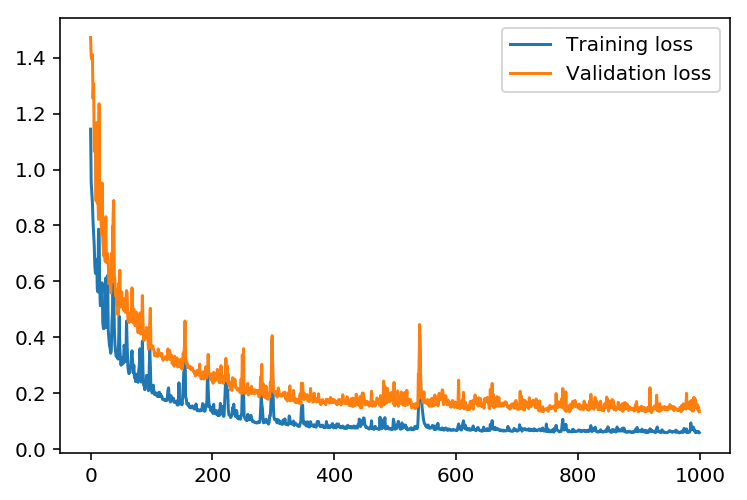

In [31]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

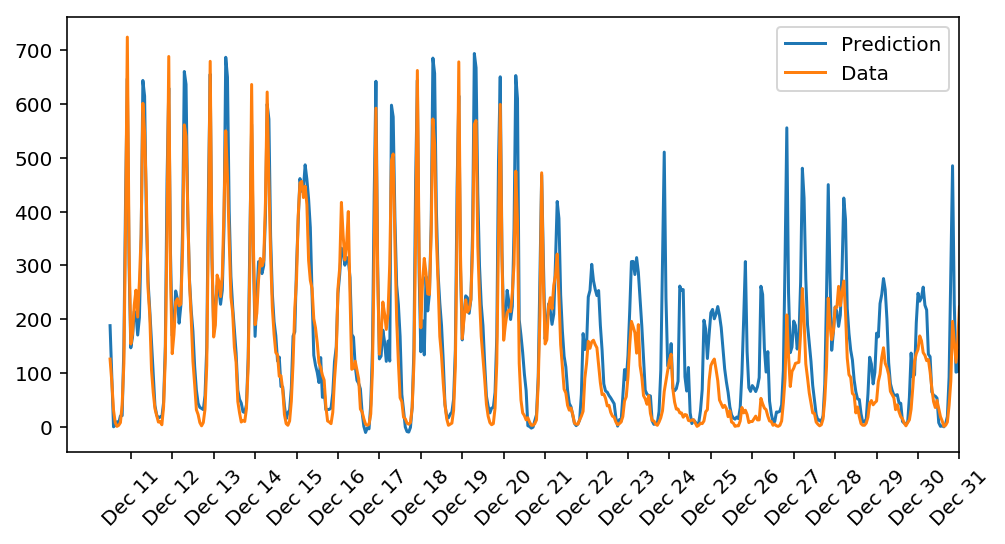

In [33]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below

I think model predicts demand quite well. THe biggest problem comes from the difficult period of christmas and new year.  It fails quite big on Christmas Eve and following holidays. 